# Preprocessing
Preprocess raw listings to use in visualization and model training notebooks

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

### Read Raw Listings
Read Home and Condo raw listings.

In [2]:
# Family Homes
home_df = pd.read_csv('../data/raw/home_listings.csv')

# Condos
condo_df = pd.read_csv('../data/raw/condo_listings.csv')

raw_listings = pd.concat([home_df, condo_df], axis=0, ignore_index=True)
listings_df = raw_listings.copy()

display(listings_df.head())
print("Number of listings: " + str(len(listings_df)))

,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_date,year_of_construction,municipal_eval,price
0,2 Storey,2 storey,1191.3,4076.29,3.0,1.0,2.0,Beauport,202012.0,2004.0,256000.0,332500.0
1,Bungalow,Open area,1261.0,9500.00,2.0,1.0,1.0,Deschambault,202112.0,1957.0,150500.0,265000.0
2,Townhouse,NaN,1645.0,1360.00,3.0,1.0,3.0,Mercier,202111.0,2006.0,479400.0,612000.0
3,Bi-generation,Link,2024.0,17000.00,4.0,3.0,1.0,Stoneham,202112.0,2019.0,NaN,526500.0
4,2 Storey,Waterfront,1469.0,16970.00,4.0,2.0,2.0,Trois-Rivières,202111.0,1925.0,NaN,NaN


Number of listings: 169894


### Subtype
Filter out subtypes with too few values.

In [3]:
listings_df['subtype'].value_counts(dropna=False)

Bungalow                        48502
2 Storey                        38477
Condominium                     28902
Semi-detached                   24858
Townhouse                       10140
Bi-generation                    8006
Split Level                      4158
1 1/2 Storey                     4046
Country Home                      659
Mobile home                       611
Acreage / Hobby Farm / Ranch      531
3 Storey                          363
Manufactured home                 184
Loft                              170
Bi-Level                          161
Villa                              63
Penthouse                          41
Misc.                              14
4 Storey                            8
Name: subtype, dtype: int64

Keep: Bungalow, 2 Storey, Condominium, Semi-detached, Townhouse, Bi-generation, Split Level, 1 1/2 Storey

In [4]:
subtypes = listings_df['subtype'].value_counts()
listings_df = listings_df[listings_df['subtype'].isin(subtypes.keys()[0:9])]

print("Number of listings: " + str(len(listings_df)))

Number of listings: 167748


### Style
Replace NaN styles with Unknown. Keep all other values.

In [5]:
listings_df['style'].value_counts(dropna=False).iloc[0:12]

NaN                     33608
2 storey                30921
Open area               25655
Detached                15325
Divided Co-Ownership    12145
Waterfront               5948
Link                     4333
Bungaloft                3948
New construction         3729
Side split               3334
Semi-detached            3298
Rural                    3039
Name: style, dtype: int64

In [6]:
listings_df['style'] = listings_df['style'].fillna('Unknown')

styles = listings_df['style'].value_counts()
listings_df = listings_df[listings_df['style'].isin(styles.keys())]

print("Number of listings: " + str(len(listings_df)))

Number of listings: 167748


### Living Area
Remove outliers and replace NaN values with mean value.

In [7]:
listings_df['living_area'].value_counts(dropna=False).iloc[0:10]

960.00     5363
1800.00    4813
1560.00    4157
1645.00    3823
1267.00    3816
2024.00    3812
1469.00    3812
1261.00    3809
2400.35    3801
1191.30    3794
Name: living_area, dtype: int64

Remove Outliers

In [8]:
min_living_area = 500
max_living_area = 4000

In [9]:
listings_df = listings_df[listings_df['living_area'] >= min_living_area]
listings_df = listings_df[listings_df['living_area'] <= max_living_area]
listings_df['living_area'] = listings_df['living_area'].astype(int)

Replace NaNs with mean

In [10]:
mean_living_area = listings_df['living_area'].dropna().mean()
print("Mean Living Area: " + str(mean_living_area))

# Fill the NaN living areas with the mean value
listings_df['living_area'] = listings_df['living_area'].fillna(mean_living_area)

Mean Living Area: 1345.422774965148


Final value distribution of living area.

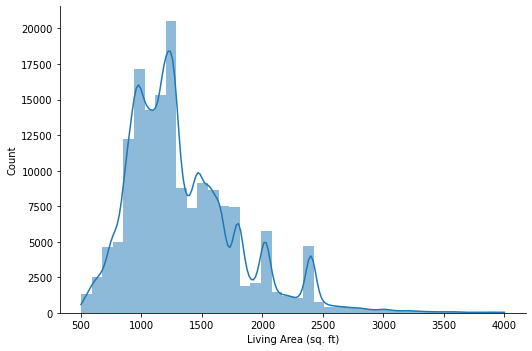

In [11]:
ax = sns.displot(listings_df, x='living_area', kde=True, fill=True, bins=40, height=5, aspect=1.5, linewidth=0)
ax.set(xlabel="Living Area (sq. ft)")
plt.savefig('./figures/living-area-hist.png', transparent=True)

In [12]:
print("Number of listings: " + str(len(listings_df)))

Number of listings: 163548


### Lot Dimensions
Replace outliers and NaN values with mean.

In [13]:
listings_df['lot_dimensions'].value_counts(dropna=False).iloc[0:5]

NaN        22806
17000.0     3877
9500.0      3866
10100.0     3805
6157.0      3804
Name: lot_dimensions, dtype: int64

In [14]:
# Mean value
mean_lot_dimensions = listings_df[listings_df['lot_dimensions'] < 50000]['lot_dimensions'].dropna().mean()

# Mean value without outliers (over 30k sq.ft)
mean_lot_dimensions_no_outliers = listings_df[listings_df['lot_dimensions'] < 30000]['lot_dimensions'].dropna().mean()

print("Mean Lot Dimensions: " + str(mean_lot_dimensions))
print("Mean Lot Dimensions without outliers: " + str(mean_lot_dimensions_no_outliers))

Mean Lot Dimensions: 9084.889465803617
Mean Lot Dimensions without outliers: 7800.64033760437


In [15]:
# Replace outliers with mean value.
listings_df.loc[(listings_df['lot_dimensions'] > 30000), 'lot_dimensions'] = mean_lot_dimensions

# Replace NaN lot dimensions with mean value without outliers.
listings_df['lot_dimensions'] = listings_df['lot_dimensions'].fillna(mean_lot_dimensions_no_outliers)

listings_df['lot_dimensions'] = listings_df['lot_dimensions'].astype(int)

Final value distribution for lot dimensions.

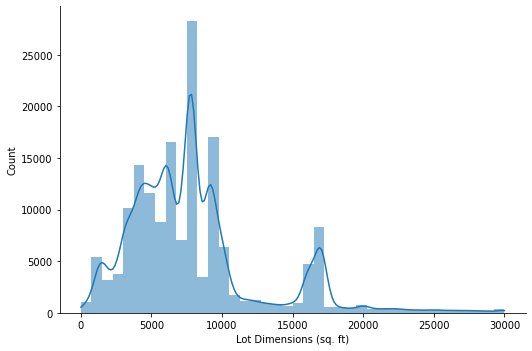

In [16]:
ax = sns.displot(listings_df, x='lot_dimensions', kde=True, fill=True, bins=40, height=5, aspect=1.5, linewidth=0)
ax.set(xlabel="Lot Dimensions (sq. ft)")
plt.savefig('./figures/lot-dimensions-hist.png', transparent=True)

In [17]:
print("Number of listings: " + str(len(listings_df)))

Number of listings: 163548


### Bedrooms, Bathrooms & Levels
No more than 7 bedrooms, 5 bathrooms and 4 stories.

In [18]:
listings_df = listings_df[listings_df['bedrooms'] <= 7]
listings_df = listings_df[listings_df['bathrooms'] <= 5]
listings_df = listings_df[listings_df['levels'] <= 4]

listings_df['bedrooms'] = listings_df['bedrooms'].astype(int)
listings_df['bathrooms'] = listings_df['bathrooms'].astype(int)
listings_df['levels'] = listings_df['levels'].astype(int)

In [19]:
print("Number of listings: " + str(len(listings_df)))

Number of listings: 158320


### Listing Date
Convert to datetime.

In [20]:
listings_df['listing_date'].value_counts(dropna=False).iloc[0:5]

202112.0    21313
202111.0    11741
201907.0     4946
202012.0     4659
202109.0     4423
Name: listing_date, dtype: int64

In [21]:
listings_df['listing_date'] = pd.to_datetime(listings_df['listing_date'], format='%Y%m')
print("Number of listings: " + str(len(listings_df)))
listings_df.head()

Number of listings: 158320


,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_date,year_of_construction,municipal_eval,price
0,2 Storey,2 storey,1191,4076,3,1,2,Beauport,2020-12-01,2004.0,256000.0,332500.0
1,Bungalow,Open area,1261,9500,2,1,1,Deschambault,2021-12-01,1957.0,150500.0,265000.0
2,Townhouse,Unknown,1645,1360,3,1,3,Mercier,2021-11-01,2006.0,479400.0,612000.0
3,Bi-generation,Link,2024,17000,4,3,1,Stoneham,2021-12-01,2019.0,NaN,526500.0
4,2 Storey,Waterfront,1469,16970,4,2,2,Trois-Rivières,2021-11-01,1925.0,NaN,NaN


### Year of Construction
Replace NaNs and outliers with mean value. Convert to int.

In [22]:
listings_df['year_of_construction'].value_counts(dropna=False).iloc[0:5]

NaN       16235
2006.0     7226
2004.0     6994
1989.0     5766
1975.0     5034
Name: year_of_construction, dtype: int64

In [23]:
temp_listings_df = listings_df.copy()
temp_listings_df = temp_listings_df[temp_listings_df['year_of_construction'] > 1700]
temp_listings_df = temp_listings_df[temp_listings_df['year_of_construction'] < 2022]

mean_year_of_construction = temp_listings_df['year_of_construction'].dropna().mean()

print("Mean Year of Construction: " + str(mean_year_of_construction))

Mean Year of Construction: 1990.4456950192866


In [24]:
listings_df['year_of_construction'] = listings_df['year_of_construction'].fillna(mean_year_of_construction)
listings_df.loc[(listings_df['year_of_construction'] < 1700), 'year_of_construction'] = mean_year_of_construction
listings_df.loc[(listings_df['year_of_construction'] > 2022), 'year_of_construction'] = mean_year_of_construction

listings_df['year_of_construction'] = listings_df['year_of_construction'].astype(int)

In [25]:
print("Number of listings: " + str(len(listings_df)))

Number of listings: 158320


### Municipal Evaluation
Dropping this feature.

In [26]:
listings_df['municipal_eval'].value_counts(dropna=False).iloc[0:5]

NaN         79967
256000.0     3859
150500.0     3816
209200.0     3811
251100.0     3806
Name: municipal_eval, dtype: int64

In [27]:
drop_municipal_eval = True

In [28]:
if drop_municipal_eval:
    listings_df = listings_df.drop(['municipal_eval'], axis=1)
else:
    listings_df = listings_df[listings_df['municipal_eval'] > 2000]
    listings_df = listings_df[listings_df['municipal_eval'] < 1000000]
    listings_df['municipal_eval'] = listings_df['municipal_eval'].astype(int)

    sns.distplot(listings_df['municipal_eval'])

In [29]:
print("Number of listings: " + str(len(listings_df)))

Number of listings: 158320


### Price
Drop NaNs, replace outliers with mean value. Convert to int.

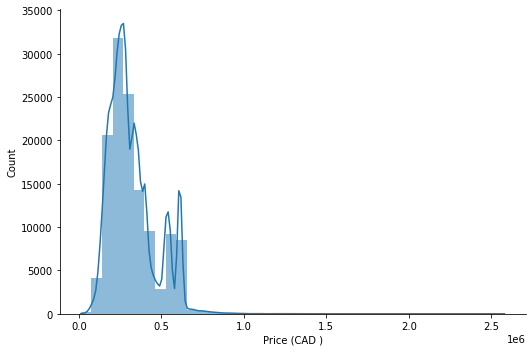

In [30]:
ax = sns.displot(listings_df, x='price', kde=True, fill=True, bins=40, height=5, aspect=1.5, linewidth=0)
ax.set(xlabel="Price (CAD )")
plt.savefig('./figures/price-hist-orig.png', transparent=True)

In [31]:
drop_nan = True
drop_outliers = True

min_price = 2000
max_price = 1000000

In [32]:
if drop_nan:
    listings_df = listings_df.dropna()
if drop_outliers:
    listings_df = listings_df[listings_df['price'] >= min_price]
    listings_df = listings_df[listings_df['price'] <= max_price]

In [33]:
mean_price = listings_df['price'].dropna().mean()
print("Mean Price: " + str(mean_price))

Mean Price: 320670.8474428948


In [34]:
listings_df['price'] = listings_df['price'].fillna(mean_price)
listings_df.loc[(listings_df['price'] < 2000), 'price'] = mean_price
listings_df.loc[(listings_df['price'] > 1000000), 'price'] = mean_price

listings_df['price'] = listings_df['price'].astype(int)

print("Number of listings: " + str(len(listings_df)))

Number of listings: 127703


Final value distribution for price.

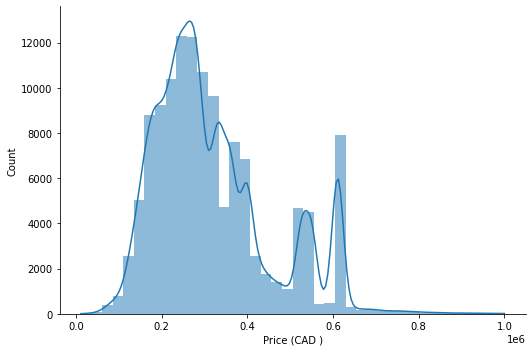

In [35]:
ax = sns.displot(listings_df, x='price', kde=True, fill=True, bins=40, height=5, aspect=1.5, linewidth=0)
ax.set(xlabel="Price (CAD )")
plt.savefig('./figures/price-hist.png', transparent=True)

### Location

Format Raw Location Strings

In [36]:
unknown_locations_dict = {
    "L'Ile Des Soeurs": "Ile des soeurs",
    "St-Denis-sur-Mer": "Saint-Denis",
    "St-Simon-De-Rimouski": "Saint-Simon",
    "St-Guillaume-D'Upton": "Saint-Guillaume",
    "St-Joseph-De-Ham-Sud": "Ham-Sud",
    "St-Adelphe-De-Champlain": "Saint-Adelphe",
    "St-Mathieu-De-Laprairie": "Saint-Mathieu",
    "St-Isidore-De-Laprairie": "Saint-Isidore",
    "St-Stanislas-De-Champlain": "Saint-Denis",
    "St-Sebastien-De-Frontenac": "Saint-Sebastien",
    "Ste-Francoise-De-Lotbiniere": "Saint-Francoise",
    "Sheenboro": "Pontiac"
}

listings_df = listings_df.replace({'location': unknown_locations_dict})

In [37]:
listings_df['location'] = listings_df['location'].str.replace('St-', 'Saint-')
listings_df['location'] = listings_df['location'].str.replace('Ste-', 'Sainte-')
listings_df['location'] = listings_df['location'].str.replace('Sts-', 'Saints-')
listings_df['location'] = listings_df['location'].str.replace('ND-', 'Notre-Dame-')
listings_df['location'] = listings_df['location'].str.replace('JC', 'Jacques-Cartier')

Replace locations using pre defined mapper.

In [38]:
with open('../data/processed/location_mapper.pkl', 'rb') as f:
    location_mapper = pickle.load(f)

In [39]:
listings_df = listings_df.replace({'location': location_mapper})

In [40]:
listings_df.head()

,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_date,year_of_construction,price
0,2 Storey,2 storey,1191,4076,3,1,2,Lévis,2020-12-01,2004,332500
1,Bungalow,Open area,1261,9500,2,1,1,Portneuf,2021-12-01,1957,265000
2,Townhouse,Unknown,1645,1360,3,1,3,Mercier,2021-11-01,2006,612000
3,Bi-generation,Link,2024,17000,4,3,1,Stoneham-et-Tewkesbury,2021-12-01,2019,526500
5,Semi-detached,2 storey,2400,4471,4,2,2,Gatineau,2021-12-01,1989,360000


### New Columns

Listing Year

In [41]:
listings_df.insert(8, 'listing_year', '')
listings_df['listing_year'] = pd.DatetimeIndex(listings_df['listing_date']).year
listings_df = listings_df[listings_df['listing_year'] <= 2021]

In [42]:
listings_df['listing_year'] = listings_df['listing_year'].astype(int)

Age

In [43]:
listings_df.insert(9, 'age', '')
listings_df['age'] = listings_df['listing_year'] - listings_df['year_of_construction']
listings_df = listings_df[listings_df['age'] >= 0]

In [44]:
listings_df['age'] = listings_df['age'].astype(int)

Yard Area

In [45]:
listings_df.insert(10, 'yard_area', '')
listings_df['yard_area'] = listings_df['lot_dimensions'] - listings_df['living_area']
listings_df['yard_area'] = listings_df['yard_area'].mask(listings_df['yard_area'].lt(0), 0)

In [46]:
listings_df['yard_area'] = listings_df['yard_area'].astype(int)

In [47]:
listings_df.head()

,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_year,age,yard_area,listing_date,year_of_construction,price
0,2 Storey,2 storey,1191,4076,3,1,2,Lévis,2020,16,2885,2020-12-01,2004,332500
1,Bungalow,Open area,1261,9500,2,1,1,Portneuf,2021,64,8239,2021-12-01,1957,265000
2,Townhouse,Unknown,1645,1360,3,1,3,Mercier,2021,15,0,2021-11-01,2006,612000
3,Bi-generation,Link,2024,17000,4,3,1,Stoneham-et-Tewkesbury,2021,2,14976,2021-12-01,2019,526500
5,Semi-detached,2 storey,2400,4471,4,2,2,Gatineau,2021,32,2071,2021-12-01,1989,360000


In [48]:
print("Original Data Length: " + str(len(raw_listings)))
print("Processed Data Length: " + str(len(listings_df)))

Original Data Length: 169894
Processed Data Length: 127605


### Save Data

In [49]:
listings_df.to_csv('../data/processed/processed_listings.csv', index=False)